### Data Analysis (test, validation)

- we will compute total area within a shape geometry and compare with the SIC25k output
- we will subset by date range and shape

In [3]:
# Load packages
from pw_data import SIC25k, clip_data  # Custom class to handle sea ice concentration data (NSIDC 25k)
import numpy as np  # For numerical operations
import pandas as pd  # For working with DataFrames and exporting data
import geopandas as gpd  # For handling geospatial data (e.g., shapefiles)
import xarray as xr
import rioxarray
import rasterio

In [4]:
# Define dataset and variable information
erddap_id = 'nsidcG02202v4nh1day'  # ERDDAP ID for daily sea ice concentration data
area_id = 'pstere_gridcell_N25k'  # ID for the corresponding area grid
crs = 'epsg:3413'  # EPSG code for the polar stereographic projection
var_name = 'cdr_seaice_conc'  # The variable name in the dataset

regions = dict([
      ('AlaskanArctic', 'arctic_sf.shp'),  # Alaskan Arctic region
      ('NorthernBering', 'nbering_sf.shp'),  # Northern Bering Sea region
      ('EasternBering', 'ebering_sf.shp'),  # Eastern Bering Sea region
    ('SoutheasternBering', 'se_bering_sf.shp') # Southeastern Bering Sea region
])


In [5]:
# Instantiate an SIC25k object and load sea ice concentration and grid data
sic_m = SIC25k(erddap_id, var_name, crs)  # Initialize SIC25k with ERDDAP data
sic_m.load_area(area_id)  # Load the corresponding grid cell area data

/Users/sunbak/miniforge3/envs/seaice/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc' has multiple fill values {-1, 255} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Unable to load data: 'NoneType' object is not subscriptable


/Users/sunbak/miniforge3/envs/seaice/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc' has multiple fill values {-1, 255} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [27]:
# Check ds
sic_m.ds

<xarray.DataArray 'cdr_seaice_conc' (time: 16507, ygrid: 448, xgrid: 304)> Size: 9GB
dask.array<clip, shape=(16507, 448, 304), dtype=float32, chunksize=(246, 448, 304), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 132kB 1978-10-25 ... 2024-03-31
  * ygrid        (ygrid) float32 2kB 5.838e+06 5.812e+06 ... -5.338e+06
  * xgrid        (xgrid) float32 1kB -3.838e+06 -3.812e+06 ... 3.738e+06
    spatial_ref  int64 8B 0
Attributes: (12/13)
    ancillary_variables:  stdev_of_cdr_seaice_conc qa_of_cdr_seaice_conc
    colorBarMaximum:      1.0
    colorBarMinimum:      0.0
    colorBarPalette:      KT_ice
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    ...                   ...
    ioos_category:        Ice Distribution
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    references:           https://nsidc.org/data/g02202/versions/4/
    standard_name:        sea_ice_area_fraction
    units:                1
    valid_range:          [0. 1.]

In [28]:
# Check area
sic_m.area


<xarray.DataArray 'cell_area' (ygrid: 448, xgrid: 304)> Size: 1MB
dask.array<open_dataset-cell_area, shape=(448, 304), dtype=float64, chunksize=(448, 304), chunktype=numpy.ndarray>
Coordinates:
  * ygrid        (ygrid) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
  * xgrid        (xgrid) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
    spatial_ref  int64 8B 0
Attributes:
    colorBarMaximum:        700000000.0
    colorBarMinimum:        300000000.0
    comment:                Surface area of grid cell
    coverage_content_type:  image
    ioos_category:          Unknown
    long_name:              Grid Cell area
    standard_name:          cell_area
    units:                  meters^2
    valid_range:            [3.82658854e+08 6.64448303e+08]

In [29]:
import matplotlib.pyplot as plt

# Check area data
areas = sic_m.area.values.flatten()
# plt.figure(figsize=(10, 6))
# plt.hist(areas, bins=50)
# print(f'How many are nan values: {np.sum(np.isnan(areas))}')
# print(f'Not nan values: {np.sum(~np.isnan(areas))}')

assert np.sum(np.isnan(areas)) == 0 
assert np.sum(~np.isnan(areas)) == (448*304)

ds_vals = sic_m.ds[0].values.flatten()
np.sum(np.isnan(ds_vals)) #63707

63707

#### Mask data with shape geometries

In [7]:

# Load shape geometries
alaska_shp = gpd.read_file(f'resources/akmarineeco/se_bering_sf.shp')  # Read shapefile
alaska_shp_proj = alaska_shp.to_crs(crs)  # Reproject the shapefile to match the dataset CRS

# Clip ds and area with the shape
ds, area = clip_data(sic_m.ds[0], alaska_shp_proj), clip_data(sic_m.area, alaska_shp_proj)

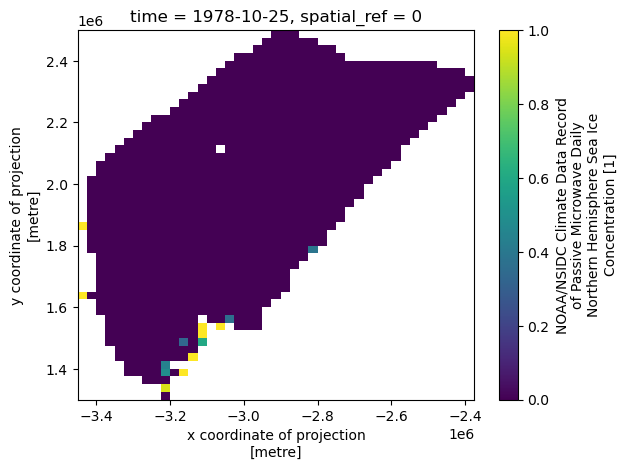

In [31]:
ds.plot()

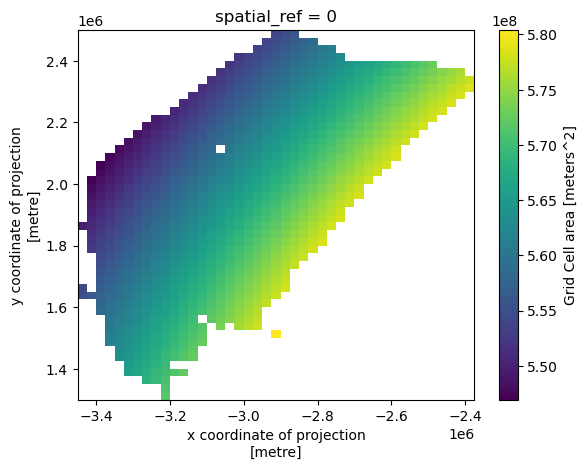

In [32]:
area.plot()

#### Mask irrelevant data (flag grid cell) and compute total area

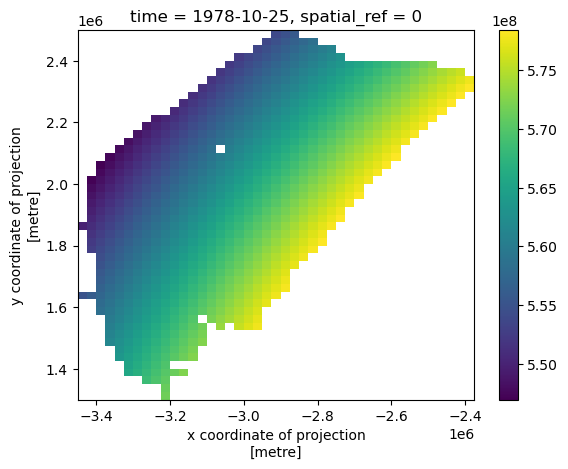

In [33]:
# Computing total area within the shape
ds = xr.where(ds.notnull(), 1, np.nan)
totalarea = ds * area
totalarea.plot()
tot_area = (totalarea.sum(dim=['xgrid', 'ygrid'], skipna=True).values) / 1e6


#### Compare the calculated data with the Class output

In [22]:
sic_tot_area = sic_m.get_total_area_km(alaska_shp_proj)
sic_tot_area

assert tot_area == sic_tot_area

NameError: name 'tot_area' is not defined

#### Subset by date range and shape geometries

In [9]:
year = 2019
ds, area = sic_m.subset_dim([f'{year-1}-09-01', f'{year}-08-31'], alaska_shp_proj)
print(ds.shape)
print(area.shape)

(365, 48, 43)
(48, 43)


#### Test the transformation of the sea ice concentration value to be 0, 1, or nan

In [21]:
import matplotlib.pyplot as plt

# Check area data
sic = sic_m.format_sic(ds, 0.15)  # Sea ice concentration thresholding

# Get unique values, excluding NaN
unique_values = np.unique(sic.values[~np.isnan(sic.values)])
print(unique_values)




Min SIC: 0.0, Max SIC: 1.0
